In [1]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

### Introduction

In [5]:
g = nx.Graph()
g.add_edge('a','b', weight = 0.1)
g.add_edge('b','c', weight = 1.5)
g.add_edge('a','c', weight = 1.0)
g.add_edge('c','d', weight = 2.2)

In [6]:
print nx.shortest_path(g, 'b', 'd')

['b', 'c', 'd']


In [7]:
print nx.shortest_path(g, 'b', 'd', weight='weight')

['b', 'a', 'c', 'd']


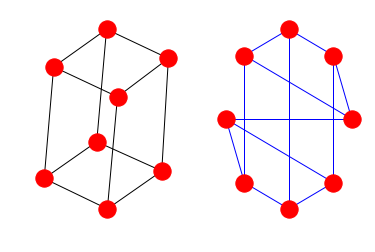

In [23]:
plt.subplot(121)
G = nx.cubical_graph()
nx.draw(G)
plt.subplot(122)
nx.draw(G, pos=nx.circular_layout(G), nodecolor='b', edge_color='b')

In [2]:
with open('soc-sign-bitcoinalpha.csv', 'r') as f:
    read_data = f.read()
f.close()

In [7]:
G = nx.DiGraph()
G.add_node(read_data)

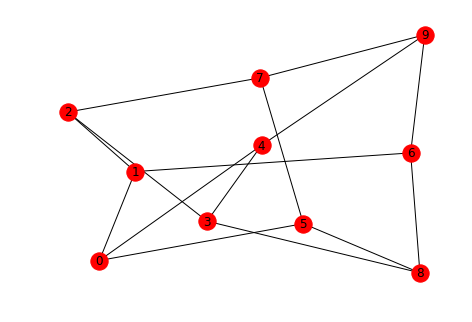

In [29]:
petersen = nx.petersen_graph()
nx.draw(petersen, with_labels=True)

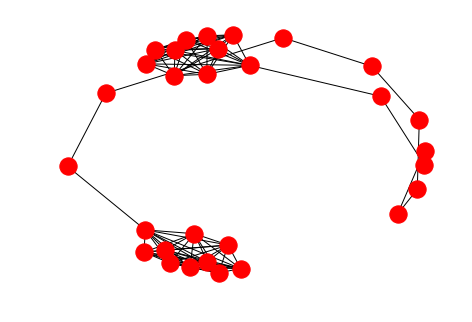

In [21]:
barbell = nx.barbell_graph(10,10)
nx.draw(barbell)

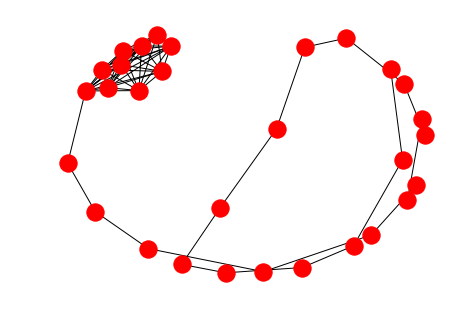

In [22]:
lollipop = nx.lollipop_graph(10,20)
nx.draw(lollipop)

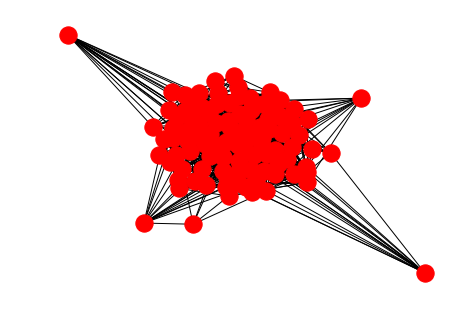

In [23]:
er = nx.erdos_renyi_graph(100,0.15)
nx.draw(er)

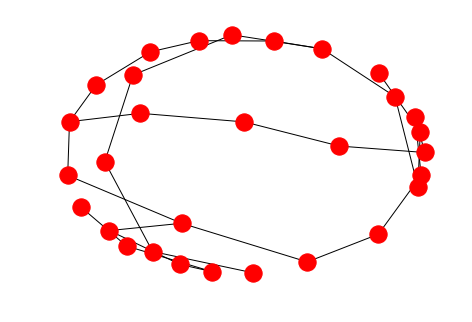

In [25]:
ws = nx.watts_strogatz_graph(30, 3, 0.1)
ba = nx.barabasi_albert_graph(100, 5)
red = nx.random_lobster(100, 0.9, 0.9)
nx.draw(ws)

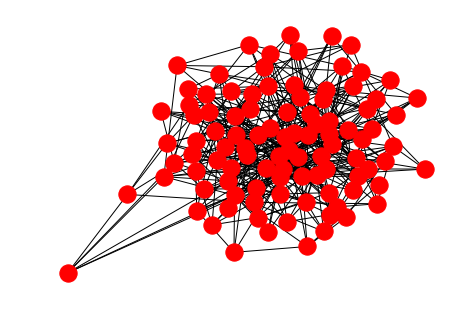

In [26]:
nx.draw(ba)

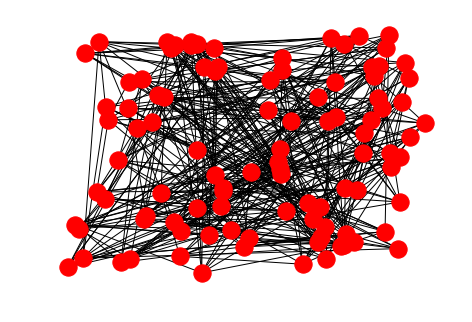

In [7]:
g = nx.watts_strogatz_graph(100, 8, 0.1)
nx.draw_random(g)

### Data processing

In [20]:
gbitcoin = nx.read_edgelist('com-amazon.ungraph.txt', delimiter='\t', 
                            create_using = nx.Graph(), nodetype = int,
                            encoding='utf-8')
N, V = gbitcoin.order(),  gbitcoin.size()
nx.write_edgelist(gbitcoin, 'edgelist.txt', delimiter=' ', encoding='utf-8')

In [21]:
print("Nodes: {:d}".format(N))

Nodes: 334863


In [22]:
print("Edges: {:d}".format(V))

Edges: 925872


In [23]:
avg_deg = float(V)/N
avg_deg

2.7649277465709856

### Degree distribution

In [26]:
print(nx.clustering(gbitcoin))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [29]:
jupyter notebook --generate-config
#c.Spawner.args = ['--NotebookApp.iopub_data_rate_limit=1000000000']

SyntaxError: invalid syntax (<ipython-input-29-92ce16869393>, line 1)

In [ ]:
avg_clust = sum()

### Layout visualization

In [1]:
print("er")

er


### SIR MODEL

In [4]:
import nepidemix

In [5]:
import numpy as np
def print_error(st):
    raise ValueError(st)

def print_info(st,nl=False):
    if nl:
        print('')
    print('$!', st)

# Defining a network object
class network(object):
    
    def __init__(self):
        self.size = 0
        self.skk = 0
        self.con = None
        self.ini = None
        self.k = None
        
    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__)

# Read edges from file
def readEdges(fname):
    netw = network()
        
    tmp_con = []
    print_info('Reading file...')
    with open(fname, 'rt') as f:
        for i in f:
            li = list(map(int , i.strip().split(','))) # change ',' if another type
            if li[0] == li[1]:
                print_error('Self-connection found! Verify your data.')
            if li[0] < 1 or li[1] < 1:
                print_error('Vertex id MUST be >= 1. Verify your data.')
            
            netw.size = max(netw.size, li[0], li[1])
            tmp_con.append(li)
            netw.skk += 2
            
    # Now let's build the adjacency list. Numpy is used to use less memory.
    print_info('Building the adjacency list...')
    netw.k = np.zeros(netw.size, np.int)
    netw.ini = np.zeros(netw.size, np.int)
    netw.con = np.zeros(netw.skk, np.int)
    
    pos = 0
    print_info('Calculating degrees...')
    for x, y in tmp_con:
        netw.k[x-1] += 1
        netw.k[y-1] += 1
        
    for i in range(0,netw.size):
        netw.ini[i] = pos
        pos = pos + netw.k[i]
            
    # Now we read again the tmp_con and save data (reindex! Nodes begin at zero)
    print_info('Connecting edges...')
    tmp_pos = np.copy(netw.ini)
    for x,y in tmp_con:
        netw.con[tmp_pos[x-1]] = y - 1
        tmp_pos[x-1] += 1
        netw.con[tmp_pos[y-1]] = x - 1
        tmp_pos[y-1] += 1
        
    return netw

In [25]:
from math import log
import sys

# READING PARAMETERS
if len(sys.argv) < 3:
    print_error('You must enter input and output names as arguments!')

fnInput = "input.txt"
fnOutput = "output.txt"

print_info('Reading dynamical parameters...')
    
dynp_sam = int(input('How much dynamics samples? '))
dynp_lb = float(input('Value of infection rate lambda (mu is defined as equal to 1): '))
dynp_tmax = int(input('Maximum time steps (it stops if the absorbing state is reached): '))
dynp_pINI = float(input('Fraction of infected vertices on the network as initial condition (is random \
for each sample): '))
# / READING PARAMETERS

# LOADING NETWORK
print_info('Loading network to memory...')
netw = readEdges(fnInput)
print_info('Everything ok!')
# / LOADING NETWORK

# PREPARING THE NECESSARY THINGS
net_kmax = max(netw.k)                      # Used in the rejection probability
avg_rho = np.zeros(dynp_tmax, np.float64)   # Average for rho at times t, averaged
avg_t = np.zeros(dynp_tmax, np.float64)
avg_sam = np.zeros(dynp_tmax, np.int)       # number of samples for each time t
avg_samSurv = np.zeros(dynp_tmax, np.int)   # and of survivng ones

dyn_VI = np.zeros(netw.size, np.int)        # list V^I
dyn_sig = np.zeros(netw.size, np.int)       # sigma
# / PREPARING THE NECESSARY THINGS

# RUNNING DYNAMICS
print_info('Running dynamics...', True)

dyn_dt_pos_max = 0 # Auxiliar
for sam in range(1,dynp_sam+1):
    print_info('Sample #'+str(sam), True)

    # Initial conditions
    print_info('Initial condition...')
    dyn_sig[:] = 0.0
    dyn_VI[:] = 0.0
    dyn_NI = 0      # N_I
    dyn_Nk = 0      # N_k
    
    # Sort vertices and apply the initial condition
    for i in range(0, int(netw.size*dynp_pINI)):
        while True:
            ver = np.random.randint(0,netw.size)
            if dyn_sig[ver] == 0:
                dyn_VI[dyn_NI] = ver
                dyn_NI += 1
                dyn_sig[ver] = 1
                dyn_Nk += netw.k[ver]
                break
    
    # Run dynamics
    dyn_t = 0
    dyn_dt = 0.0
    dyn_dt_pos = 1
    
    print_info('Running...')
    
    while dyn_t <= dynp_tmax and dyn_NI > 0:
        # SIS-OGA ALGORITHM
        
        # Calculate the total rate
        dyn_R = (dyn_NI + 1.0*dynp_lb * dyn_Nk)
        
        # Select the time step
        rnd = max(np.random.uniform(),1e-12) # Avoid u = 0
        dyn_dt = -log(rnd) / dyn_R
        
        # Update the time
        dyn_t += dyn_dt
        
        # Probability m to heal
        dyn_m = 1.0*dyn_NI / dyn_R
        
        if np.random.uniform() < dyn_m: # Select a random occupied vertex and heal.
            pos_inf = np.random.randint(0,dyn_NI)
            ver = dyn_VI[pos_inf]
                
            # Then, heal it
            dyn_sig[ver] = 0
            dyn_Nk -= netw.k[ver]
            dyn_NI -= 1
            dyn_VI[pos_inf] = dyn_VI[dyn_NI]
        else: # If not, try to infect: w = 1 - m
            # Select the infected vertex i with prob. proportional to k_i
            while True:
                pos_inf = np.random.randint(0,dyn_NI)
                ver = dyn_VI[pos_inf]
                if np.random.uniform() < 1.0*netw.k[ver] / (1.0*net_kmax):
                    break
            
            # Select one of its neighbors
            pos_nei = np.random.randint(netw.ini[ver], netw.ini[ver] + netw.k[ver])
            ver = netw.con[pos_nei]
            
            if dyn_sig[ver] == 0: # if not a phantom process, infect
                dyn_sig[ver] = 1
                dyn_Nk += netw.k[ver]
                dyn_VI[dyn_NI] = ver    # Add one element to list
                dyn_NI += 1             # Increase by 1 the list
                       
                       
            # Try to save the dynamics by time unit
            while (dyn_t >= dyn_dt_pos): # Save data
                avg_rho[dyn_dt_pos - 1] += 1.0*dyn_NI/netw.size
                avg_t[dyn_dt_pos - 1] += dyn_t
                avg_sam[dyn_dt_pos - 1] += 1
                if dyn_NI != 0: 
                    avg_samSurv[dyn_dt_pos - 1] += 1
                    dyn_dt_pos_max = max(dyn_dt_pos,dyn_dt_pos_max) # The maximum t with non-null rho
                dyn_dt_pos += 1
                
            # if a absorbing state is reached, exit
    
    # Write output file
    flOutput = open(fnOutput, 'wt')
    print(  '## ***** Algorithm used: Optimized Gillespie Algorithm for SIS (SIS-OGA, Python) *****',
            '#@ Network file: '+fnInput,
            '#@ Number of nodes: '+str(netw.size),
            '#@ Number of edges: '+str(netw.skk),
            '#@ Samples: '+str(dynp_sam),
            '#! Infection rate (lambda): '+str(dynp_lb),
            '#! Maximum time steps: '+str(dynp_tmax),
            '#! Fraction of infected vertices (initial condition): '+str(dynp_pINI))
            
    for dt_pos in range(0,dyn_dt_pos_max):
        print(1.0*avg_t[dt_pos]/avg_sam[dt_pos], 1.0*avg_rho[dt_pos]/(1.0*sam))#, file=flOutput)
        # If you use /avg_samSurv[dt_pos] instead of /(1.0*sam) to write avg_rho (2nd column), you have 
        # QS analysis :)
                
    flOutput.close()
# / RUNNING DYNAMICS

print_info('')
print_info('Everything ok!',True)
print_info('Input file (edges list): '+ fnInput)
#print_info('Output file: '+ fnOutput)

('$!', 'Reading dynamical parameters...')
How much dynamics samples? 5
Value of infection rate lambda (mu is defined as equal to 1): 1
Maximum time steps (it stops if the absorbing state is reached): 10
Fraction of infected vertices on the network as initial condition (is random for each sample): 0.5
('$!', 'Loading network to memory...')
('$!', 'Reading file...')
('$!', 'Building the adjacency list...')
('$!', 'Calculating degrees...')
('$!', 'Connecting edges...')
('$!', 'Everything ok!')

('$!', 'Running dynamics...')

('$!', 'Sample #1')
('$!', 'Initial condition...')
('$!', 'Running...')
('## ***** Algorithm used: Optimized Gillespie Algorithm for SIS (SIS-OGA, Python) *****', '#@ Network file: input.txt', '#@ Number of nodes: 5', '#@ Number of edges: 10', '#@ Samples: 5', '#! Infection rate (lambda): 1.0', '#! Maximum time steps: 10', '#! Fraction of infected vertices (initial condition): 0.5')
(1.0307990177399715, 0.80000000000000004)
(2.0333352109828069, 0.59999999999999998)
(3